In [1]:
from ultralytics import YOLO
from result_functions import interpret_result, keypart2index, keypoint2index
import cv2

import zone_functions

from PIL import Image

import torch
import numpy as np
from matplotlib import pyplot as plt, patches

In [199]:
model = YOLO("yolov8n-pose.pt", task="pose")
results = model.predict(source="0", show=True, stream=True, verbose=False)

In [3]:
lean_detector = zone_functions.LeanDetector()

In [4]:
watch_time = 300
wait_time = 50
timings = [watch_time, wait_time, watch_time, wait_time, watch_time]
time_step = 0

In [5]:
selects = []
stored_results = []
for result in results:
    orig_img = result.orig_img
    keypoints = result.keypoints

    points = keypoints.xy[0][[
    keypoint2index["left shoulder"], 
    keypoint2index["right shoulder"], 
    keypoint2index["right hip"], 
    keypoint2index["left hip"]
    ]]
    points_np = points.cpu().int().numpy()
    tilt = points_np[0:2,0].mean() - points_np[2:4,0].mean()
    tip = points_np[0:2,1].mean() - points_np[2:4,1].mean()
    hips_y = points_np[2:4,1].mean()

    gray_image = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)

    mask = np.zeros(gray_image.shape, dtype=np.uint8)
    mask = cv2.fillPoly(mask, [points_np], (255))
    selected_values = gray_image[mask > 0]

    values = [selected_values.mean(), selected_values.std(), tilt, tip, hips_y]

    mode = "INTERIM"
    if time_step == 0:
        mode = "up"
    elif time_step == 2:
        mode = "forward"
    elif time_step == 4:
        mode = "backward"

    print(mode)

    if mode != "INTERIM":
        stored_results.append(result)
        lean_detector.add_lean(values, mode)

    timings[time_step] -= 1
    if timings[time_step] == 0:
        time_step += 1
    if time_step == len(timings):
        break

1/1: 0... Success  (inf frames of shape 640x480 at 30.00 FPS)



up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
up
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTERIM
INTE

In [60]:
lean_detector.stored_lean_values_n = np.array(lean_detector.stored_lean_values)
lean_detector.stored_lean_values_n -= lean_detector.stored_lean_values_n.mean(axis=0)
lean_detector.stored_lean_values_n /= lean_detector.stored_lean_values_n.std(axis=0)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay

import seaborn


In [89]:
feature_names = ["mean", "std", "tilt", "tip", "hips"]
class_names = ["up", "forward", "backward"]
class_weights = {0:5, 1:2, 2:1}

Plots

<AxesSubplot:>

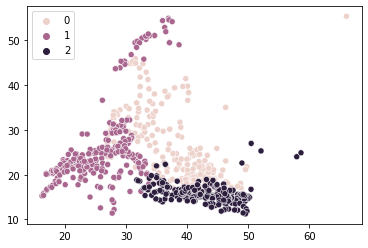

In [90]:
seaborn.scatterplot(x=np.array(lean_detector.stored_lean_values)[:,0], 
                    y=np.array(lean_detector.stored_lean_values)[:,1], 
                    hue=lean_detector.stored_lean_classes)

<AxesSubplot:>

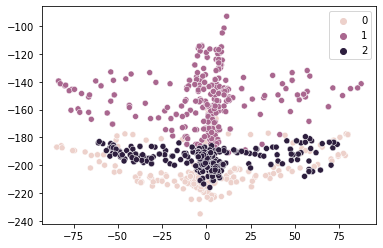

In [91]:
seaborn.scatterplot(x=np.array(lean_detector.stored_lean_values)[:,2], 
                    y=np.array(lean_detector.stored_lean_values)[:,3], 
                    hue=lean_detector.stored_lean_classes)

<AxesSubplot:>

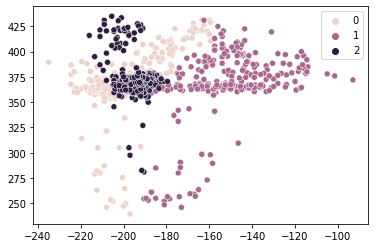

In [92]:
seaborn.scatterplot(x=np.array(lean_detector.stored_lean_values)[:,3], 
                    y=np.array(lean_detector.stored_lean_values)[:,4], 
                    hue=lean_detector.stored_lean_classes)

In [186]:
visible_features = [0, 1, 2, 3, 4]
feature_names = np.array(feature_names)[visible_features]
X_train, X_test, y_train, y_test = train_test_split(np.array(lean_detector.stored_lean_values_n)[:,visible_features], lean_detector.stored_lean_classes, 
                                                    test_size=0.9, random_state=42)

K-Nearest Neighbors

<AxesSubplot:>

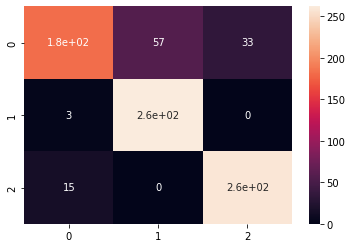

In [187]:
kneighbors_classifier = KNeighborsClassifier(n_neighbors=21)
kneighbors_classifier.fit(X_train, y_train)
kneighbords_y_pred = kneighbors_classifier.predict(X_test)
kneighbors_cm = confusion_matrix(y_true=y_test, y_pred=kneighbords_y_pred)

seaborn.heatmap(kneighbors_cm, annot=True)

Decision Tree

Importance of mean -> 0.13132781410609434
Importance of std -> 0.29357942255056985
Importance of tilt -> 0.05003057644011076
Importance of tip -> 0.384940755526418
Importance of hips -> 0.140121431376807


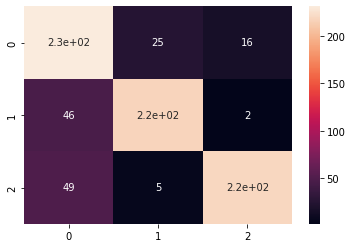

In [188]:
tree_classifier = DecisionTreeClassifier(max_depth=4, random_state=42, class_weight=class_weights)
tree_classifier.fit(X_train, y_train)
tree_y_pred = tree_classifier.predict(X_test)
tree_cm = confusion_matrix(y_true=y_test, y_pred=tree_y_pred)

seaborn.heatmap(tree_cm, annot=True)

for f_name, f_importance in zip(feature_names, tree_classifier.feature_importances_):
    print(f"Importance of {f_name} -> {f_importance}")

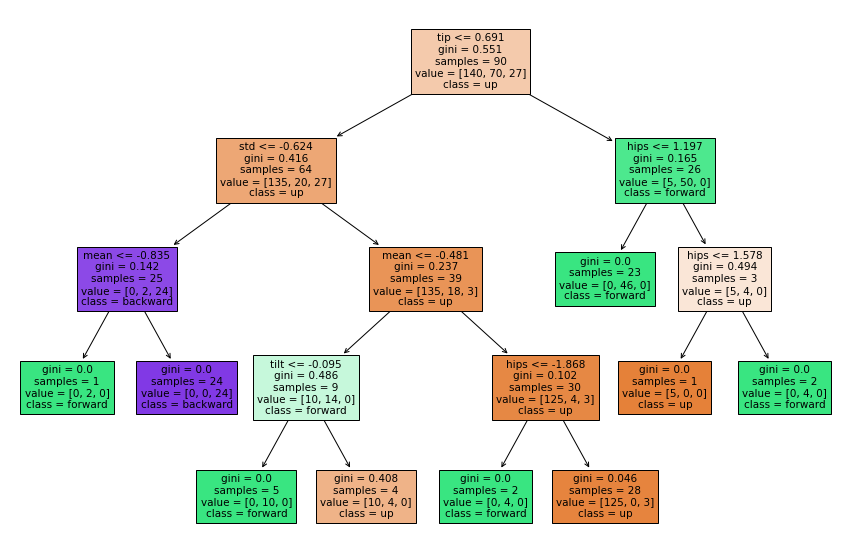

In [189]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(tree_classifier, 
                   feature_names=feature_names,  
                   class_names= class_names,
                   filled=True)

Importance of mean -> 0.25551883647404133
Importance of std -> 0.283490892355567
Importance of tilt -> 0.04467041956240767
Importance of tip -> 0.3366074902552344
Importance of hips -> 0.07971236135274959


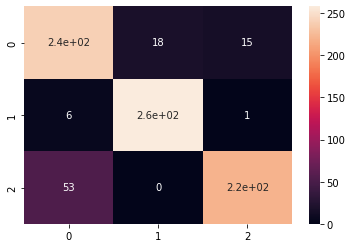

In [190]:
forest_classifier = RandomForestClassifier(max_depth=3, random_state=42, class_weight=class_weights, n_estimators=100)
forest_classifier.fit(X_train, y_train)
forest_y_pred = forest_classifier.predict(X_test)
forest_cm = confusion_matrix(y_true=y_test, y_pred=forest_y_pred)

seaborn.heatmap(forest_cm, annot=True)

for f_name, f_importance in zip(feature_names, forest_classifier.feature_importances_):
    print(f"Importance of {f_name} -> {f_importance}")

Importance of mean -> 0.2897787080013809
Importance of std -> 0.3013959844212332
Importance of tip -> 0.3395198202493567
Importance of hips -> 0.06930548732802926


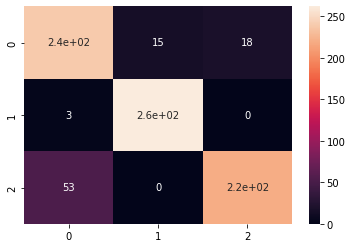

In [191]:
forest_classifier = RandomForestClassifier(max_depth=3, random_state=42, class_weight=class_weights, n_estimators=100)
forest_classifier.fit(X_train[:,[0,1,3,4]], y_train)
forest_y_pred = forest_classifier.predict(X_test[:,[0,1,3,4]])
forest_cm = confusion_matrix(y_true=y_test, y_pred=forest_y_pred)

seaborn.heatmap(forest_cm, annot=True)

for f_name, f_importance in zip(feature_names[[0,1,3,4]], forest_classifier.feature_importances_):
    print(f"Importance of {f_name} -> {f_importance}")

Support Vector Machines

array([7, 4, 4])

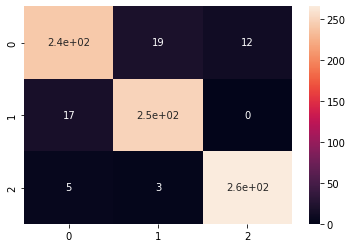

In [192]:
svm_classifier = SVC(kernel="linear", decision_function_shape="ovo", C=100, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train, y_train)
svm_y_pred = svm_classifier.predict(X_test)
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

svm_classifier.n_support_

array([18, 23, 17])

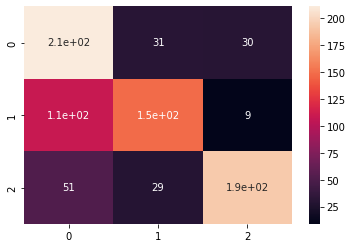

In [193]:
svm_classifier = SVC(kernel="poly", degree=4, decision_function_shape="ovo", C=100, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train, y_train)
svm_y_pred = svm_classifier.predict(X_test)
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

svm_classifier.n_support_

IMPORTANT FEATURES

array([6, 6, 6])

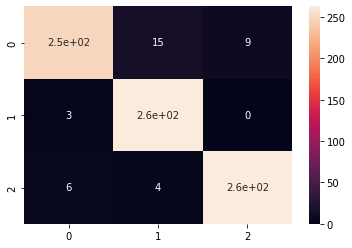

In [195]:
sel_features = [0,1,3,4]

svm_classifier = SVC(kernel="linear", decision_function_shape="ovo", C=10, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train[:, sel_features], y_train)
svm_y_pred = svm_classifier.predict(X_test[:, sel_features])
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

svm_classifier.n_support_

array([ 8, 13,  9])

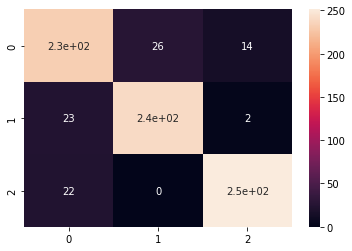

In [194]:
sel_features = [0,1,3]

svm_classifier = SVC(kernel="linear", decision_function_shape="ovo", C=10, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train[:, sel_features], y_train)
svm_y_pred = svm_classifier.predict(X_test[:, sel_features])
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

svm_classifier.n_support_

ONLY 2

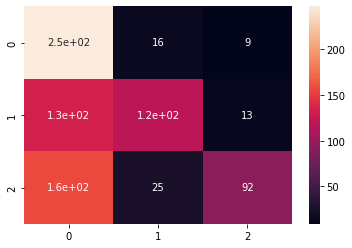

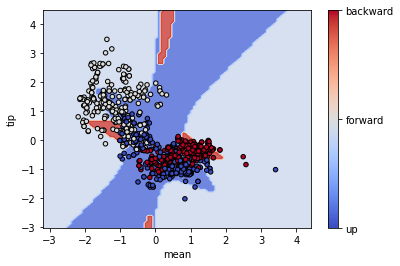

In [196]:
sel_features = [0,3]

svm_classifier = SVC(kernel="poly", degree=4, decision_function_shape="ovo", C=100, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train[:, sel_features], y_train)
svm_y_pred = svm_classifier.predict(X_test[:, sel_features])
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

fig, ax = plt.subplots()
disp = DecisionBoundaryDisplay.from_estimator(
        svm_classifier,
        X_test[:,sel_features],
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
    )
scatter = ax.scatter(X_test[:,sel_features[0]], X_test[:,sel_features[1]], c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_xlabel(feature_names[sel_features[0]])
ax.set_ylabel(feature_names[sel_features[1]])

cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(class_names)))
cbar.set_ticklabels(class_names)

plt.show()

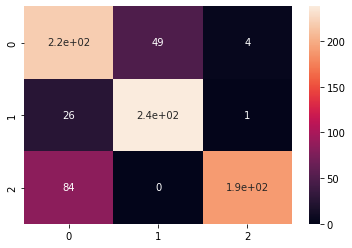

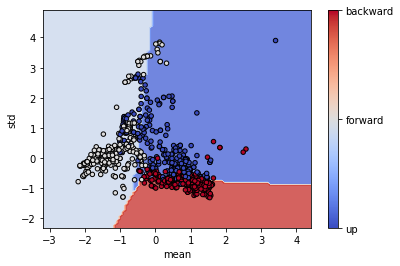

In [197]:
sel_features = [0,1]

svm_classifier = SVC(kernel="linear", decision_function_shape="ovo", C=10, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train[:, sel_features], y_train)
svm_y_pred = svm_classifier.predict(X_test[:, sel_features])
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

fig, ax = plt.subplots()
disp = DecisionBoundaryDisplay.from_estimator(
        svm_classifier,
        X_test[:,sel_features],
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
    )
scatter = ax.scatter(X_test[:,sel_features[0]], X_test[:,sel_features[1]], c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_xlabel(feature_names[sel_features[0]])
ax.set_ylabel(feature_names[sel_features[1]])

cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(class_names)))
cbar.set_ticklabels(class_names)

plt.show()

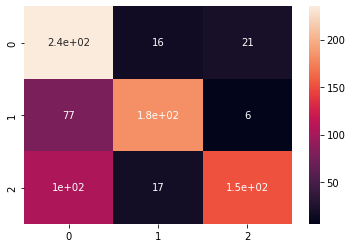

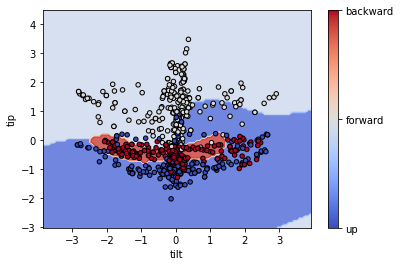

In [198]:
sel_features = [2,3]

svm_classifier = SVC(kernel="rbf", degree=2, decision_function_shape="ovo", C=10, random_state=42, class_weight=class_weights)
svm_classifier.fit(X_train[:, sel_features], y_train)
svm_y_pred = svm_classifier.predict(X_test[:, sel_features])
svm_cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)

seaborn.heatmap(svm_cm, annot=True)

fig, ax = plt.subplots()
disp = DecisionBoundaryDisplay.from_estimator(
        svm_classifier,
        X_test[:,sel_features],
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
    )
scatter = ax.scatter(X_test[:,sel_features[0]], X_test[:,sel_features[1]], c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_xlabel(feature_names[sel_features[0]])
ax.set_ylabel(feature_names[sel_features[1]])

cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(class_names)))
cbar.set_ticklabels(class_names)

plt.show()